# Clustering

In [3]:
from __future__ import annotations

from abc import abstractproperty, abstractmethod
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.extmath import cartesian
import random
from typing import List, Tuple, Iterable, Optional
import itertools
import time

In [4]:
plot = False
plot_final = True

# Step 0
- You will get a csv file from us. Load it in your language/environment.

In [5]:
df = pd.read_csv('data-clust.csv')

- Explore the data in it.

In [6]:
df

,x,y
0,3.80286,2.15835
1,5.18384,2.21139
2,3.15722,2.30568
3,5.56977,2.37613
4,4.11252,2.95963
...,...,...
1540,11.21757,3.06683
1541,9.77858,3.10110
1542,9.95852,4.07279
1543,10.82223,1.91727


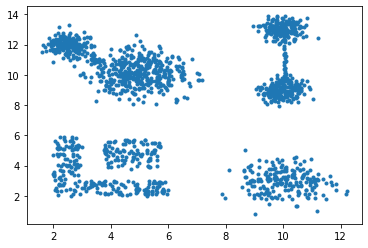

In [7]:
plt.scatter(*zip(*df.to_numpy()), marker='.')
plt.show()

## Step 1
- Implement kMeans (Lloyd)*.

In [102]:
def centroid(points: Iterable[Tuple[float, float]]) -> Optional[Tuple[float, float]]:
    x_sum, y_sum = 0, 0
    count = 0
    for x, y in points:
        x_sum += x
        y_sum += y
        count += 1
    if count == 0:
        return None
    return x_sum / count, y_sum / count

def calc_distance(first: Tuple[float, float], second: Tuple[float, float]):
    return (first[0] - second[0]) ** 2 + (first[1] - second[1]) ** 2

def index_of_nearest_centroid(centroids: List[Tuple[float, float]], point: Tuple[float, float]) -> int:
    index = -1
    min_distance = -1
    for i, c in enumerate(centroids):
        distance = calc_distance(point, c)
        if distance < min_distance or min_distance == -1:
            min_distance = distance
            index = i
    return index

def k_means(df: pd.DataFrame, k: int) -> np.ndarray:
    colormap = plt.cm.get_cmap('rainbow')
    min_x, max_x = df['x'].min(), df['x'].max()
    min_y, max_y = df['y'].min(), df['y'].max()
    
    points = df[['x', 'y']].apply(lambda x: tuple(x), axis=1).to_numpy()
    old_centroids = []
    centroids = []
    groups = {}

    for i in range(k):
        x = random.random() * (max_x - min_x) + min_x
        y = random.random() * (max_y - min_y) + min_y
        centroids.append((x, y))

    while True:
        for i in range(k):
            groups[i] = set()

        for point in points:
            index = index_of_nearest_centroid(centroids, point)
            groups[index].add(tuple(point))

        if plot:
            for index, l in groups.items():
                if l:
                    plt.scatter(*zip(*l), marker='.')

        # print centroids
        if plot:
            plt.scatter(*zip(*centroids), marker='o', c='k')

        old_centroids = centroids
        centroids = []
        
        for index, group in groups.items():
            new_centroid = centroid(group)
            if new_centroid is None:
                continue
            x, y = new_centroid
            centroids.append((x, y))
            
            
        if set(old_centroids) == set(centroids):
            break
        if plot:
            plt.show()
    if plot_final:
        for index, l in groups.items():
            if l:
                plt.scatter(*zip(*l), marker='.')
        plt.show()

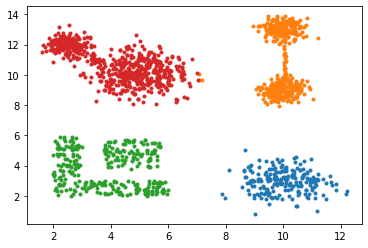

In [103]:
k_means(df, 4)

## Step 2
- Implement AGNES*. Choose at least one link criteria.

In [8]:
class Timer:
    def __init__(self, message: str, enabled=True):
        self.enabled = enabled
        self.message = message

    def __enter__(self):
        if not self.enabled:
            return
        self.start_time = time.time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        if not self.enabled:
            return
        elapsed_time = time.time() - self.start_time
        print(f'\rTIME FOR "{self.message}": {elapsed_time}', end='')

In [9]:
distance_map: Dict[Tuple[int, int], float] = dict()


In [10]:
class Node:
    next_id = 0

    def __init__(self):
        self.id = Node.next_id
        Node.next_id += 1

    def distance_to(self, other: Node) -> float:
        min_id, max_id = self.id, other.id
        if max_id > min_id:
            min_id, max_id = max_id, min_id
        if (min_id, max_id) in distance_map:
            return distance_map[min_id, max_id]

        if isinstance(self, Point) and isinstance(other, Point):
            distance = (self.x - other.x) ** 2 + (self.y - other.y) ** 2
            distance_map[min_id, max_id] = distance
            return distance

        m = 1000
        c = 0
        for point_1, point_2 in itertools.product(self.points, other.points):
            c += 1
            # local_min_id, local_max_id = point_1.id, point_2.id
            # if local_min_id > local_max_id:
            #    local_min_id, local_max_id = local_max_id, local_min_id
            d = (point_1.x - point_2.x) ** 2 + (point_1.y - point_2.y) ** 2
            # d = distance_map[local_min_id, local_max_id]
            if d < m:
                m = d
        distance_map[min_id, max_id] = m
        return m

    @property
    @abstractmethod
    def points(self) -> Set[Point]:
        pass

    @property
    @abstractmethod
    def children(self) -> Iterator[Node]:
        pass

    def __lt__(self, other: Node):
        return self.id < other.id

    def __gt__(self, other: Node):
        return self.id > other.id

    def scatter(self):
        plt.scatter(*zip(*((point.x, point.y) for point in self.points)), marker='.')


class Cluster(Node):
    def __init__(self, children: Tuple[Node, Node]):
        super().__init__()
        self._children = children
        self._points = {point for child in self.children for point in child.points}

    @property
    def points(self) -> Set[Point]:
        return self._points

    @property
    def children(self) -> Iterator[Node]:
        return self._children


class Point(Node):
    @property
    def points(self) -> Set[Point]:
        return {self}

    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    @property
    def children(self) -> Iterator[Node]:
        return iter([])

    def __repr__(self) -> str:
        return f'Point(x={self.x},y={self.y})'

In [11]:
def agnes():
    # All nodes
    all_nodes: List[Node] = [Point(row.x, row.y) for _, row in df.iterrows()]

    # Working list of available nodes
    nodes = list(all_nodes)
    random.shuffle(nodes)
    # nodes = nodes[:1000]
    node_map = {node.id: node for node in nodes}

    for point_1, point_2 in itertools.combinations(nodes, r=2):
        point_1.distance_to(point_2)

    # ignored_ids = set()
    while len(node_map) > 1:
        with Timer(f'{len(node_map)}', True):
            min_distance = 1000
            min_node_ids = None
            a = 0
            with Timer("Calculate distance", enabled=False):
                for id_pair, distance in distance_map.items():
                    # print(id_pair)
                    a += 1
                    # distance = node_1.distance_to(node_2)
                    if distance < min_distance:
                        min_distance = distance
                        min_node_ids = id_pair
            with Timer('Add new cluster', False):
                id_1, id_2 = min_node_ids
                # print(node_map)
                # print(min_node_ids)
                cluster = Cluster((node_map[id_1], node_map[id_2]))
                keys_to_delete = []
                for node_id in min_node_ids:
                    del node_map[node_id]
                    for ids, _ in distance_map.items():
                        if node_id in ids:
                            keys_to_delete.append(ids)
                for _, node in node_map.items():
                    cluster.distance_to(node)
                for a in keys_to_delete:
                    distance_map.pop(a, None)
                node_map[cluster.id] = cluster
    print(cluster)
    for t1 in cluster.children:
        for t2 in t1.children:
            for t3 in t2.children:
                t3.scatter()
    plt.show()

TIME FOR "2": 0.00881505012512207<__main__.Cluster object at 0x12007b220>


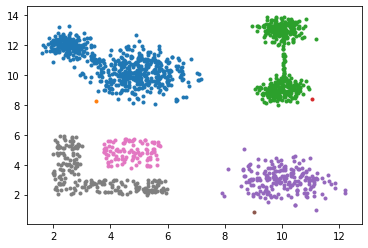

In [12]:
agnes()